## Intagrative analysis of TF dynamics using sci-mtChIL-seq datasets

In [1]:
Sys.setenv(LANGUAGE = "en")
options(warn = -1)

library(GenomicRanges)
library(GenomicFeatures)
library(slingshot)
library(Seurat)
library(Signac)
library(tidyverse)
source('R/mytools.R')

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, saveRDS, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: AnnotationDbi



In [ ]:
mgene <- genes(EnsDb.Mmusculus.v79::EnsDb.Mmusculus.v79)
seqlevelsStyle(mgene) <- "UCSC"
mgene_coding_use <- readRDS('data/out/mgene_coding_use.rds')

In [ ]:
## Create Seurat object
#
# sm <- c(
#   "RNAPII_RNAPII-MyoD_r1r2_genebody.rds",
#   "RNAPII_RNAPII-Myog_r1_genebody.rds"
#   ) %>% 
#   map(~sprintf("data/matrix/part3/%s",.x)) %>%
#   map(readRDS) %>%
#   map(cutoff) %>% ldecoyMerge() 
# meta <- tibble(cell = colnames(sm)) %>%
#   separate(cell,into = c("rep","sample","pair","ab","lib","t5"),remove = F) %>%
#   unite(label,pair,rep,remove = F) %>%
#   mutate(sample = factor(sample,levels = c("MyoDminus","D0","D24","D72"))) %>%
#   tib2df()
# 
# nih3t3tf <- CreateSeuratObject(sm,meta.data = meta,min.features = 200,min.cells = 100)
# nih3t3tf[["RNA"]] <- split(nih3t3tf[["RNA"]], f = nih3t3tf$label)
# nih3t3tf <- NormalizeData(nih3t3tf,scale.factor = 3000)
# nih3t3tf <- ScaleData(nih3t3tf)
# nih3t3tf <- FindVariableFeatures(nih3t3tf,nfeatures = Inf)
# vfs <- HVFInfo(nih3t3tf,status = TRUE) %>%
#   as_tibble(rownames = 'gene') %>%
#   filter(gene %in% mgene_coding_use$symbol) %>%
#   arrange(rank) %>% pull(gene) %>% head(10000)
# nih3t3tf <- RunPCA(nih3t3tf,features = vf_mg)
# nih3t3tf <- IntegrateLayers(
#   object = nih3t3tf,method = HarmonyIntegration,
#   orig.reduction = "pca",new.reduction = 'harmony',
#   verbose = TRUE,features = vf_mg
#   )
# nih3t3tf <- RunUMAP(nih3t3tf,dims = 2:16,n.neighbors = 30,reduction = 'harmony')
# nih3t3tf <- FindNeighbors(nih3t3tf,dims = 2:16,k.param = 30,reduction = 'harmony')
# nih3t3tf <- FindClusters(nih3t3tf,algorithm = 4,resolution = .5)

In [ ]:
nih3t3tf <- readRDS('data/seuratObject_nih3t3_RNAPII_tf.rds')
vfs <- HVFInfo(nih3t3tf,status = TRUE) %>%
  as_tibble(rownames = 'gene') %>%
  filter(gene %in% mgene_coding_use$symbol) %>%
  arrange(rank) %>% pull(gene) %>% head(10000)

### Pseudotime inference

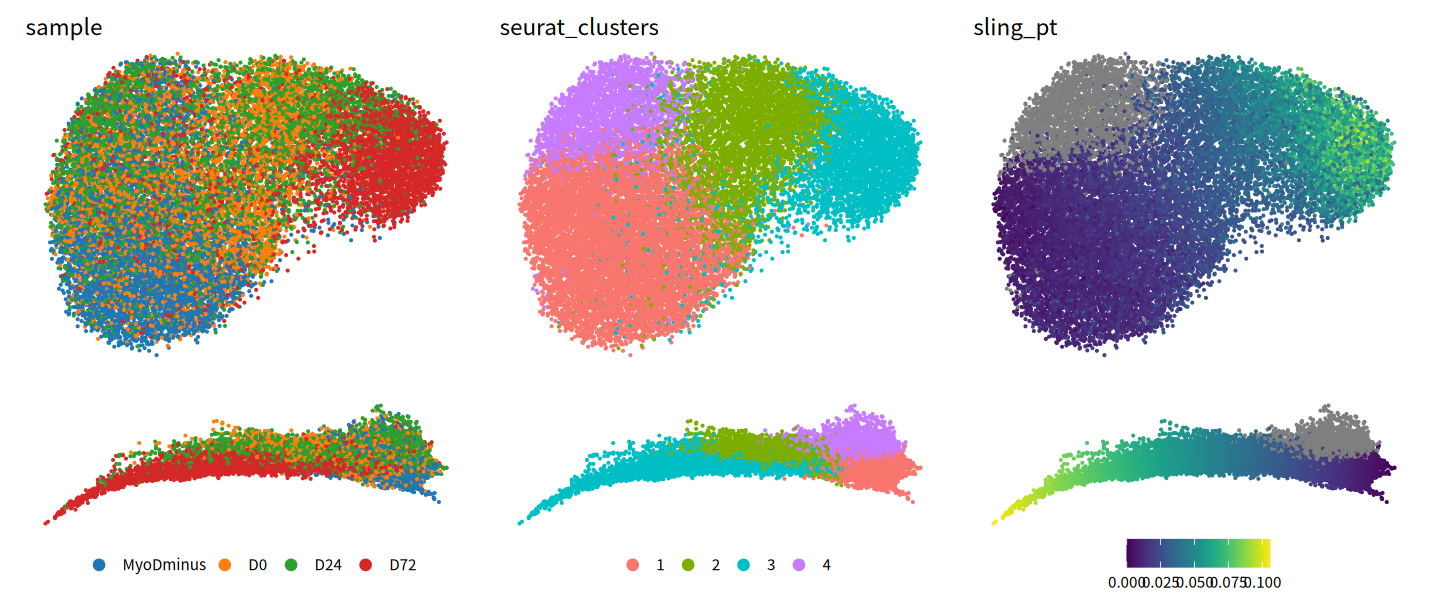

In [4]:
options(repr.plot.width = 12, repr.plot.height = 5) 
list(
  list(
    dimplot(nih3t3tf,'sample'),
    dimplot(nih3t3tf,'sample','phate') + ggtitle("")
    ) %>%
    patchwork::wrap_plots(ncol = 1,guides = 'collect') & theme_void() & theme(legend.position = 'bottom'),
  list(
    dimplot(nih3t3tf,'seurat_clusters',palette = F),
    dimplot(nih3t3tf,'seurat_clusters',"phate",palette = F) + ggtitle("")
    ) %>%
    patchwork::wrap_plots(ncol = 1,guides = 'collect') & theme_void() & theme(legend.position = 'bottom'),
  list(
    dimplot(nih3t3tf,'sling_pt'),
    dimplot(nih3t3tf,'sling_pt',"phate") + ggtitle("")
    ) %>%
    patchwork::wrap_plots(ncol = 1,guides = 'collect') & theme_void() & theme(legend.position = 'bottom')
  ) %>%
  patchwork::wrap_plots(nrow = 1)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


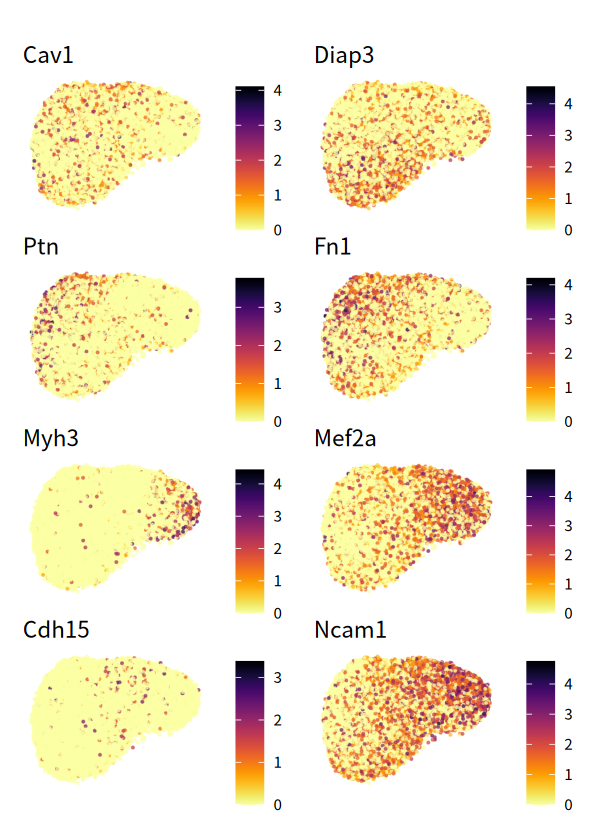

In [5]:
options(repr.plot.width = 5, repr.plot.height = 7) 
c("Cav1","Diap3",
  "Ptn","Fn1",
  "Myh3","Mef2a",
  "Cdh15","Ncam1") %>%
  dimplot(nih3t3tf,.,patchwork_ncol = 2,empha = T,Theme = theme_minimal,alpha = .6) & 
    theme(panel.grid = element_blank()) & 
    viridis::scale_color_viridis(option = "inferno", discrete = FALSE, direction = -1)

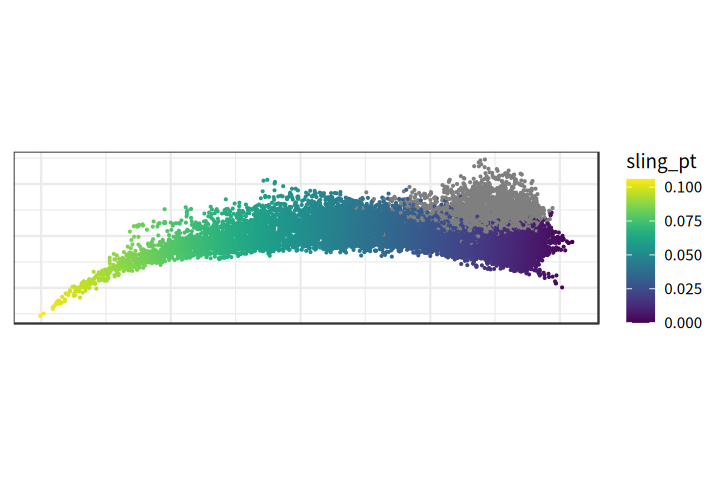

In [6]:
df <- Embeddings(nih3t3tf[['phate']]) %>% as.matrix()
clus_sling <- nih3t3tf$seurat_clusters
idx <- clus_sling %in% 1:3
lin <- getLineages(df[idx,], clus_sling[idx],start.clus = 1)
crv <- getCurves(lin)
pt <- slingPseudotime(crv) 

options(repr.plot.width = 6, repr.plot.height = 4) 
nih3t3tf %>% 
  seu2tab(emb = 'phate') %>%
  select(cell,PHATE1,PHATE2) %>%
  left_join(as_tibble(pt,rownames = 'cell'),by = 'cell') %>%
  rename(sling_pt = Lineage1) %>%
  style('sling_pt','PHATE')
# nih3t3tf <- AddMetaData(nih3t3tf,pt[,1],'sling_pt')

In [7]:
tab_pt <- seu2tab(nih3t3tf) %>%
  select(cell,pair,rep,label,sample,seurat_clusters,sling_pt)    
myodnp <- tab_pt %>%
  mutate(
    sample = ifelse(sample == 'MyoDminus','MyoDminus','MyoDplus'),
    sample = factor(sample,levels = c('MyoDplus','MyoDminus'))
    ) %>%
  select(cell,sling_pt,sample) %>% tib2df()
ratio <- sum(myodnp$sample == 'MyoDplus')/length(myodnp$sample)
balanced_data <- ROSE::ROSE(sample ~ sling_pt, data = myodnp, seed = 1)$data
ldamod <- MASS::lda(sample~sling_pt,data = balanced_data)
lda_scores <- predict(ldamod)$x
threshold_dm <- balanced_data$sling_pt[which.min(abs(lda_scores))]
threshold_dm

[1] 0.02432593

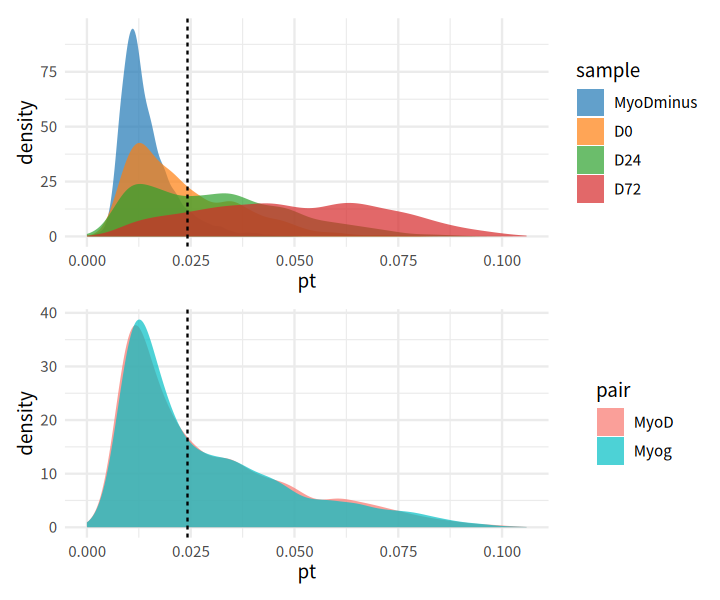

In [8]:
g1 <- tab_pt %>% na.omit() %>%
  ggplot(aes(pt,fill = sample)) +
    theme_minimal() +
    geom_density(color = NA,alpha = .7) + 
    geom_vline(xintercept = threshold_dm,linetype = 'dashed') +
    dfill
g2 <- tab_pt %>% na.omit() %>%
  ggplot(aes(pt,fill = pair)) +
    theme_minimal() +
    geom_density(color = NA,alpha = .7) +
    geom_vline(xintercept = threshold_dm,linetype = 'dashed')

options(repr.plot.width = 6, repr.plot.height = 5) 
g1/g2

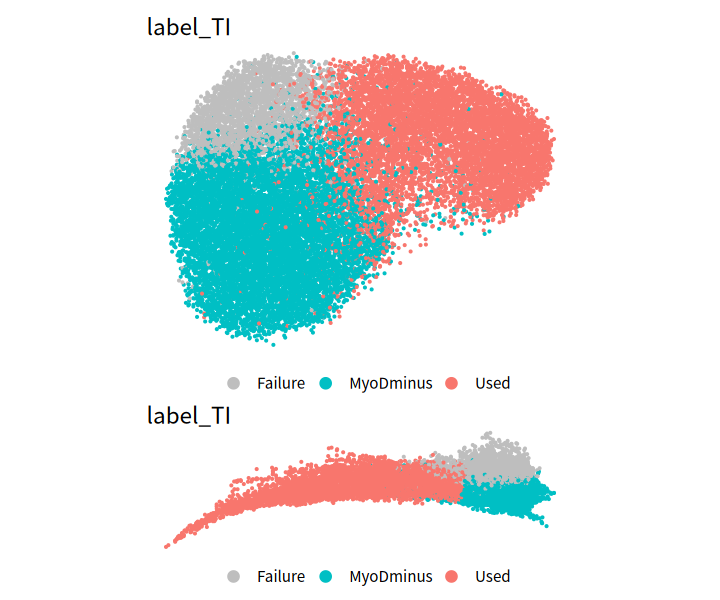

In [ ]:
sling_pt <- nih3t3tf$sling_pt
label_ti <- ifelse(
  is.na(sling_pt),'Failure',
  ifelse(sling_pt<threshold_dm,'MyoDminus','Used')
  )
sa <- nih3t3tf$sample
label_ti <- ifelse(
  sa == 'MyoDminus'&label_ti == 'Used',
  'MyoDminus',label_ti
  )
# nih3t3tf <- AddMetaData(nih3t3tf,label_ti,'label_TI')
pal_ti <- c(Used = ggColorHue(2)[1],
            MyoDminus = ggColorHue(2)[2],
            Failure = "grey")
list(
  dimplot(nih3t3tf,'label_TI',reduction = 'umap',Theme = theme_void,palette = F),
  dimplot(nih3t3tf,'label_TI',reduction = 'phate',Theme = theme_void,palette = F)
  ) %>%
  patchwork::wrap_plots(guide = 'collect',ncol = 1) &
  scale_color_manual(values = pal_ti) & theme(legend.position = 'bottom')

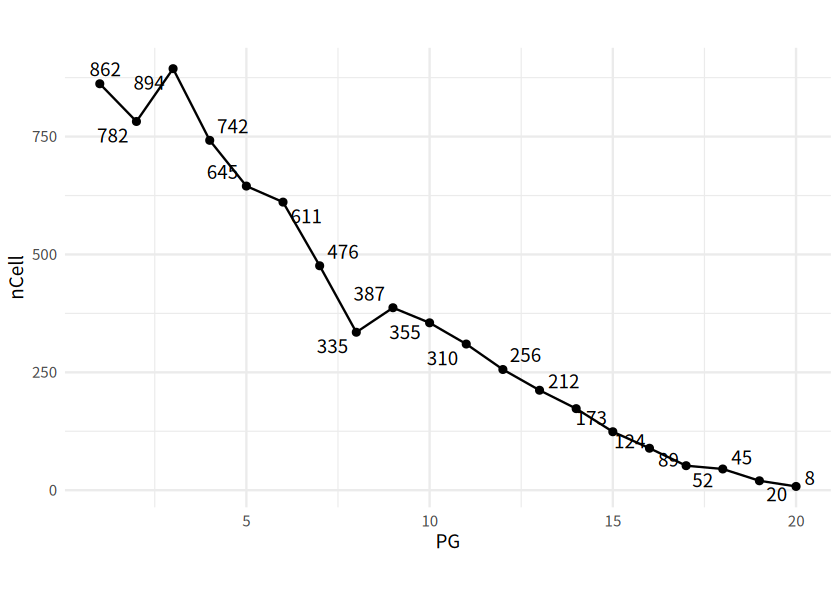

In [10]:
nbin <- 20

tab_pt2 <- seu2tab(nih3t3tf) %>%
  select(cell,sample,label_TI,sling_pt)
tab_pt2 <- bind_rows(
  tab_pt2 %>%
    filter(label_TI == 'Used') %>%
    mutate(
      PG = as.double(cut(sling_pt, breaks = nbin, include.lowest = TRUE)) 
      ),
  tab_pt2 %>%
    filter(label_TI == 'MyoDminus',sample != 'MyoDminus') %>%
    mutate(PG = 0)
  ) %>%
  mutate(PG = factor(PG,levels = 0:20))

options(repr.plot.width = 7, repr.plot.height = 5) 
tab_pt2 %>% 
  count(PG) %>%
  mutate(PG = as.double(as.character(PG))) %>%
  filter(PG>0) %>%
  ggplot(aes(PG,n,label = n)) + 
    geom_line() + geom_point() + 
    theme_minimal() + theme(aspect.ratio = .6) +
    ggrepel::geom_text_repel() + labs(y = 'nCell',x = "PG")

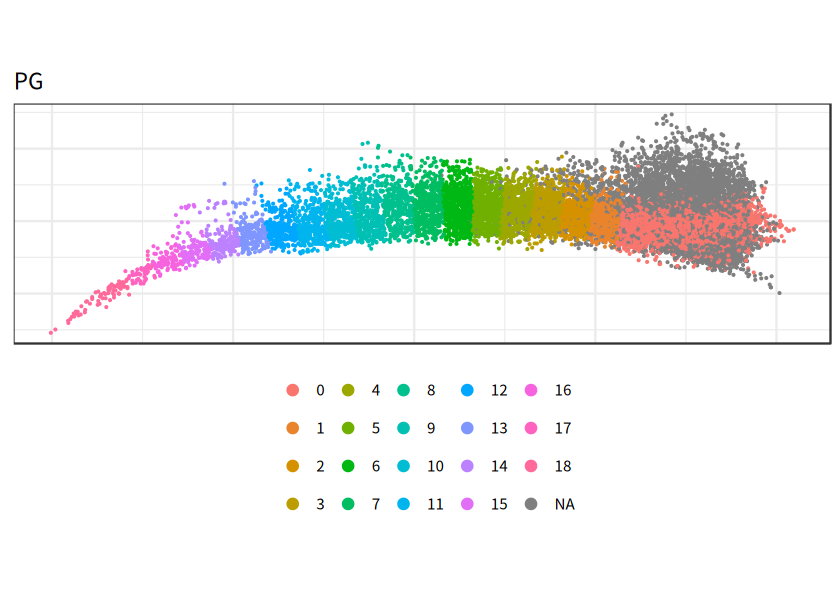

In [11]:
tab_pt2 <- tab_pt2 %>%
  mutate(
    PG = as.double(as.character(PG)),
    PG = ifelse(PG %in% 18:20,18,PG),
    PG = factor(PG,levels = 0:18)
    )
PGs <- tab_pt2 %>%
  with(structure(PG,names = cell)) 
# nih3t3tf <- AddMetaData(nih3t3tf,PGs,'PG')
dimplot(nih3t3tf,'PG','phate',palette = F,guide_ncol = 2) + theme(legend.position = 'bottom')

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


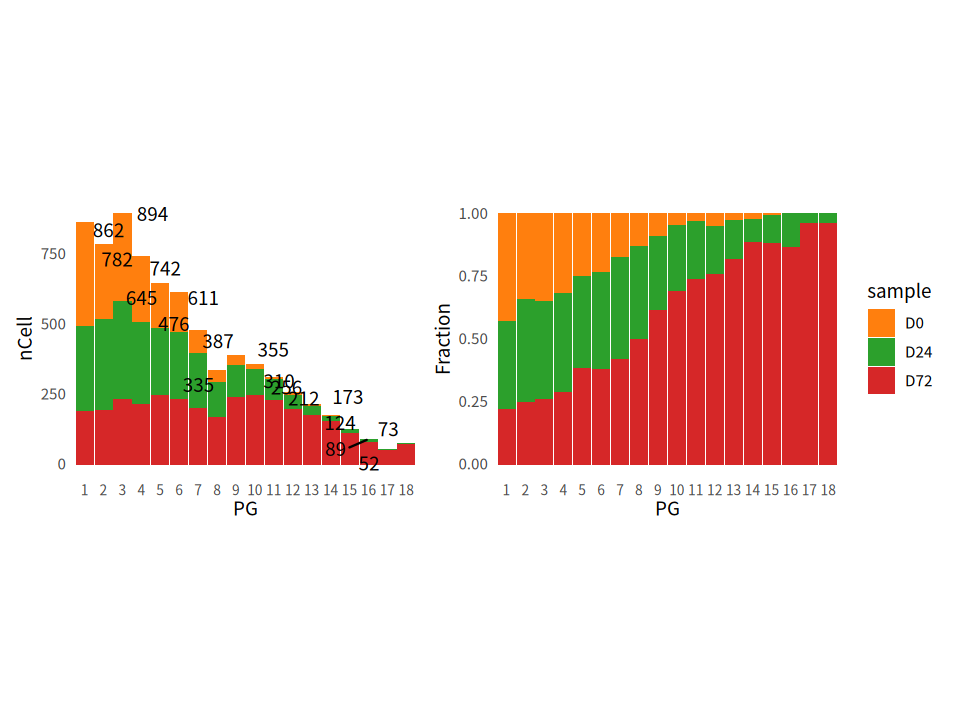

In [12]:
options(repr.plot.width = 8, repr.plot.height = 6)
nih3t3tf %>%
  seu2tab() %>% 
  filter(sample != 'MyoDminus') %>%
  filter(!is.na(PG)) %>%
  filter(PG != 0) %>%
  freqfrac('PG','sample') & 
    theme(axis.text.x = element_text(size = 8)) &
    scale_fill_manual(values = dcolor$palette(4)[-1])

### MyoD dynamics

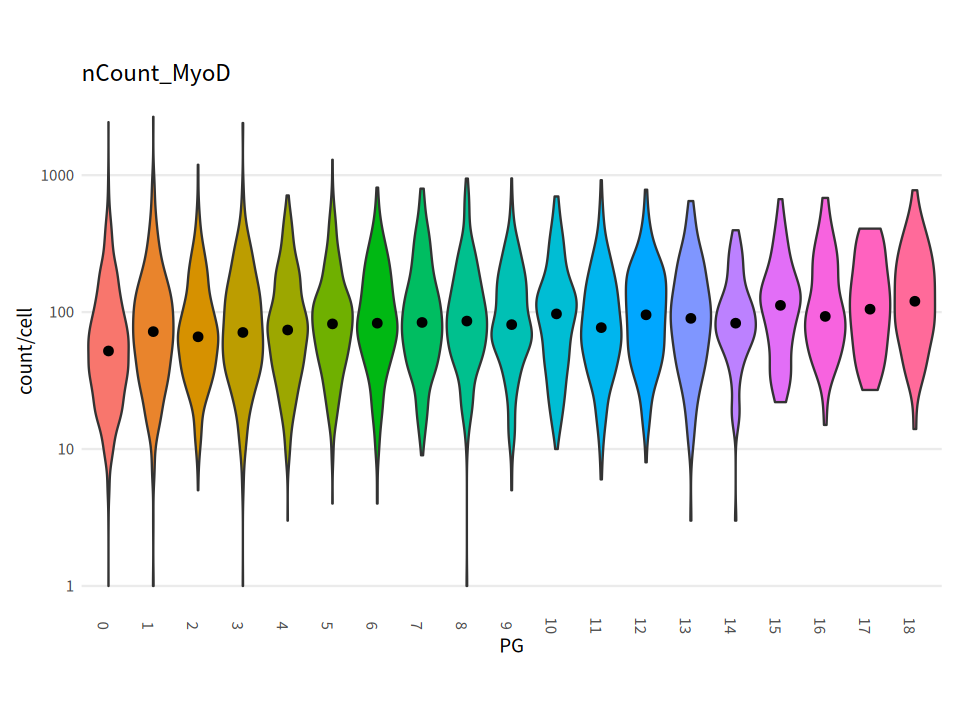

In [ ]:
so_md <- readRDS('data/seuratObject_nih3t3_MyoD_RNAPII-MyoD.rds')
nih3t3md <- subset(JoinLayers(nih3t3tf),pair == 'MyoD')
nih3t3md <- AddMetaData(nih3t3md,so_md$nCount_peaks,'nCount_MyoD')

vlnplot(nih3t3md[,!is.na(nih3t3md$PG)],feature = 'nCount_MyoD',group.by = 'PG') +
  stat_summary(fun = median,size = .3) + scale_y_log10() +
  theme(
    aspect.ratio = .6,
    axis.text.x = element_text(angle = -90) 
    ) +
  labs(y = 'count/cell')

In [14]:
mat_md <- GetAssayData(so_md,layer = 'data')
tab_pt2_ <- tab_pt2 %>%
  mutate(PG = as.double(as.character(PG))) %>%
  filter(PG != 0) %>%
  mutate(PG = as.factor(PG)) %>%
  tib2df()
cells <- intersect(rownames(tab_pt2_),colnames(mat_md))
mod1 <- with(tab_pt2_[cells,],model.matrix(~PG - 1))
mat_md <- mat_md[,cells]
mat_md <- mat_md[rowSums(mat_md>0)>=10,]

nfrag <- (mat_md>0) %*% mod1
mod1 <- 300*t(t(mod1)/colSums(mod1))
avg_mat_md <- mat_md %*% mod1

peakinfo_md <- tibble(
  reg = rownames(avg_mat_md),
  nFrag = rowSums(nfrag),
  nbin = rowSums(avg_mat_md != 0),
  var = apply(mat_md,1,var)
  )
usereg <- peakinfo_md %>%
  filter(var >= 0.2,nbin >= 5) %>%
  pull(reg)

avg_mat_md <- avg_mat_md[usereg,]
maxbin <- ncol(avg_mat_md)
scaled_avg_mat_md <- t(scale(t(avg_mat_md)))
gamres_md <- tibble(
  peak = rownames(scaled_avg_mat_md)
  ) %>%
  mutate(
    model = map(peak,~mgcv::gam(
      formula = y~s(x,bs = 'cs'),
      data = data.frame(x = 1:maxbin,y = scaled_avg_mat_md[.x,])
    ),.progress = TRUE),
    pred = map(model,~tibble(
      PG = 1:maxbin,
      predict = predict(.x)
    ),.progress = TRUE)
  )
gammat_md <- gamres_md %>%
  select(-model) %>% unnest(pred) %>%
  spread(PG,predict) %>% 
  tib2df() %>% as.matrix()
scaled_gammat_md <- gammat_md %>% 
  apply(1,function(x) (x-min(x))/max(x-min(x))) %>% t()

 ■■■                                7% |  ETA:  1m

 ■■■■■                             12% |  ETA: 50s

 ■■■■■■                            18% |  ETA: 47s

 ■■■■■■■■                          23% |  ETA: 44s

 ■■■■■■■■■                         28% |  ETA: 41s

 ■■■■■■■■■■■                       33% |  ETA: 38s

 ■■■■■■■■■■■■■                     38% |  ETA: 35s

 ■■■■■■■■■■■■■■                    43% |  ETA: 33s

 ■■■■■■■■■■■■■■■■                  49% |  ETA: 30s

 ■■■■■■■■■■■■■■■■■                 54% |  ETA: 27s

 ■■■■■■■■■■■■■■■■■■■               59% |  ETA: 24s

 ■■■■■■■■■■■■■■■■■■■■              64% |  ETA: 21s

 ■■■■■■■■■■■■■■■■■■■■■■            69% |  ETA: 18s

 ■■■■■■■■■■■■■■■■■■■■■■■           73% |  ETA: 16s

 ■■■■■■■■■■■■■■■■■■■■■■■■          77% |  ETA: 14s

 ■■■■■■■■■■■■■■■■■■■■■■■■■■        82% |  ETA: 11s

 ■■■■■■■■■■■■■■■■■■■■■■■■■■■       87% |  ETA:  8s

 ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■     92% |  ETA:  5s

 ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■    97% |  ETA:  2s

 ■■■■       

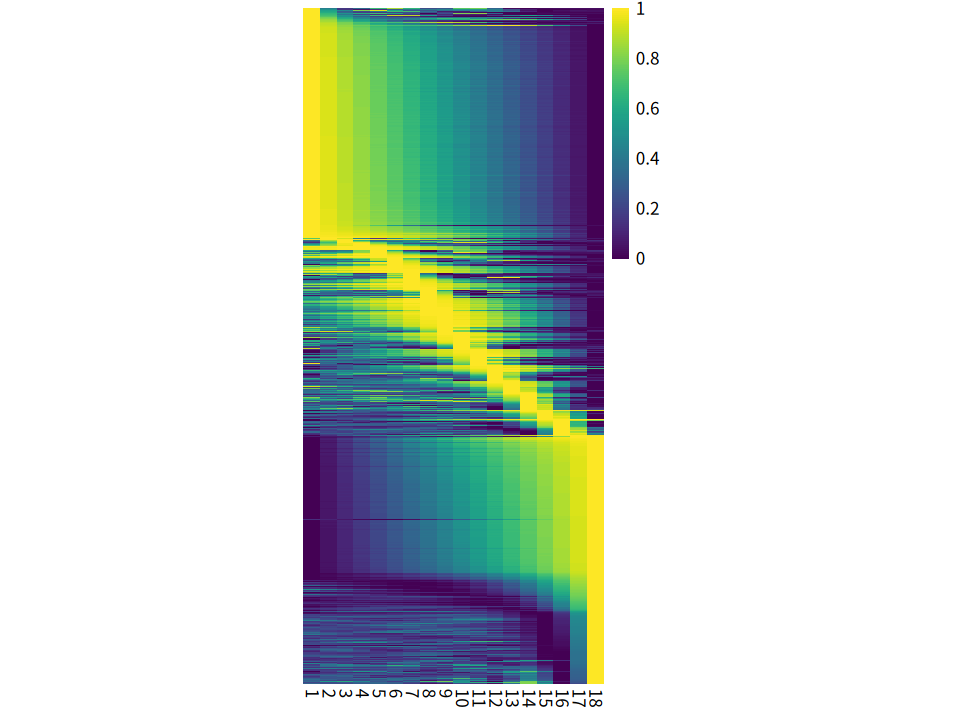

In [15]:
nbin <- ncol(scaled_gammat_md)
heat_lev_md <- scaled_gammat_md %>% 
  as_tibble(rownames = 'reg') %>%
  gather(key = PG,value = value,-reg) %>%
  mutate(PG = as.integer(PG)) %>%
  nest(.by = reg) %>%
  mutate(
    summit = map_int(data,~with(.x,PG[which.max(value)])),
    sup = ifelse(summit < nbin/2,summit+1,summit-1),
    sup = map2_dbl(data,sup,~{ .x$value[.y] }),
    sup = ifelse(summit < nbin/2,sup,-sup)
    ) %>%
  arrange(summit,sup) %>%
  pull(reg)
pheatmap::pheatmap(
  scaled_gammat_md[heat_lev_md,],
  cluster_rows = F,cluster_cols = F,
  show_rownames = F,cellwidth = 10,border_color = NA,
  color = viridis::viridis(128),
  )

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


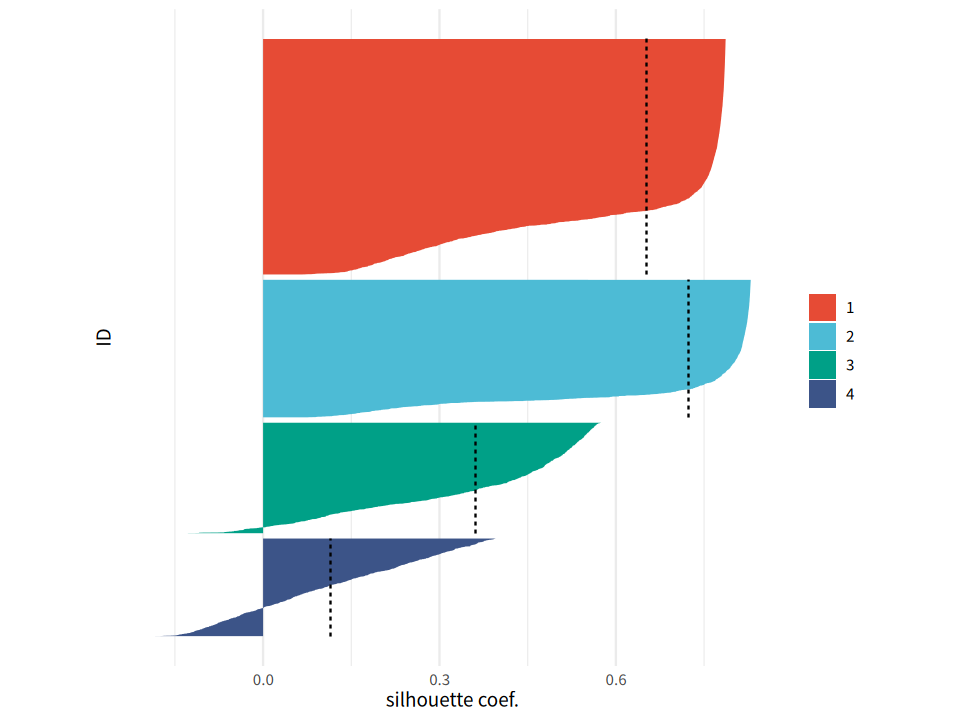

In [16]:
k <- 4
set.seed(15); km <- kmeans(scaled_gammat_md,centers = k)
lev <- with(km,table(cluster)) %>% sort(decreasing = TRUE) %>% names()
gamres_clu_md <- as.factor(as.integer(factor(km$cluster,levels = lev))) %>%
  structure(names = names(km$cluster))
names(gamres_clu_md) <- rownames(scaled_gammat_md)
#D <- dist(avg_sct)
D <- dist(scaled_gammat_md)
sil_use <- silh(D,gamres_clu_md,1:k)
sil_use[[1]] + theme(aspect.ratio = 1) + ggsci::scale_fill_npg()

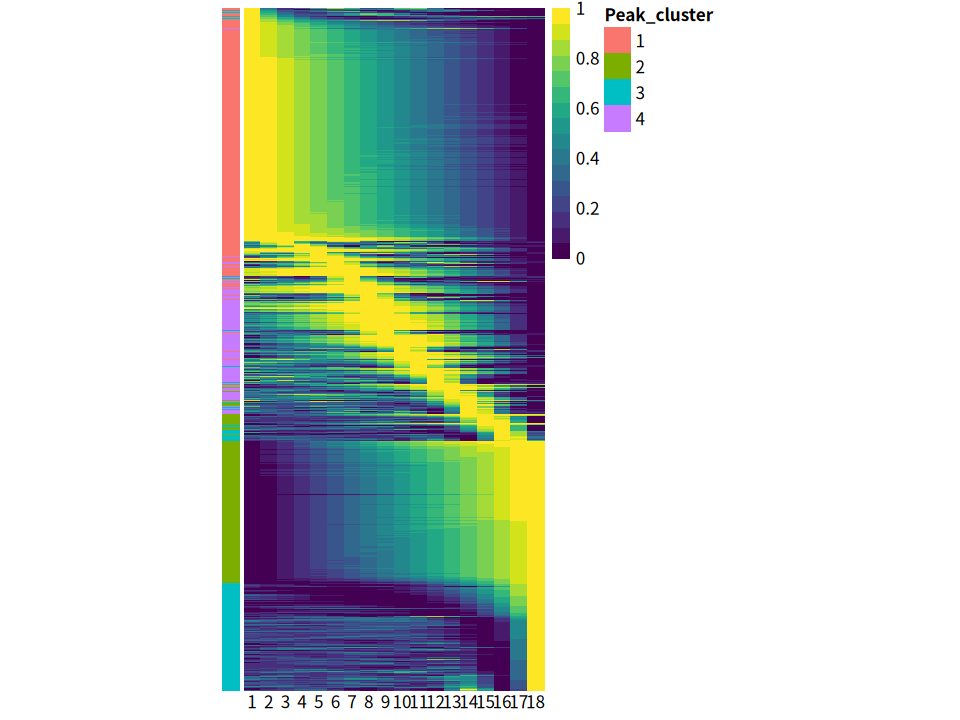

In [17]:
pal <- list(Peak_cluster = structure(ggColorHue(k),names = 1:k))
gr_que_df_md_ <- enframe(gamres_clu_md) %>%
  rename(reg = 1,Peak_cluster = 2) %>%
  mutate(Peak_cluster = as.character(Peak_cluster)) %>%
  tib2df()
pheatmap::pheatmap(
  scaled_gammat_md[heat_lev_md,],
  cluster_rows = F,cluster_cols = F,
  show_rownames = F,cellwidth = 10,border_color = NA,
  color = viridis::viridis(16),
  annotation_row = gr_que_df_md_[heat_lev_md,,drop = F],
  annotation_colors = pal,
  angle_col = 0,annotation_names_row = F
  )


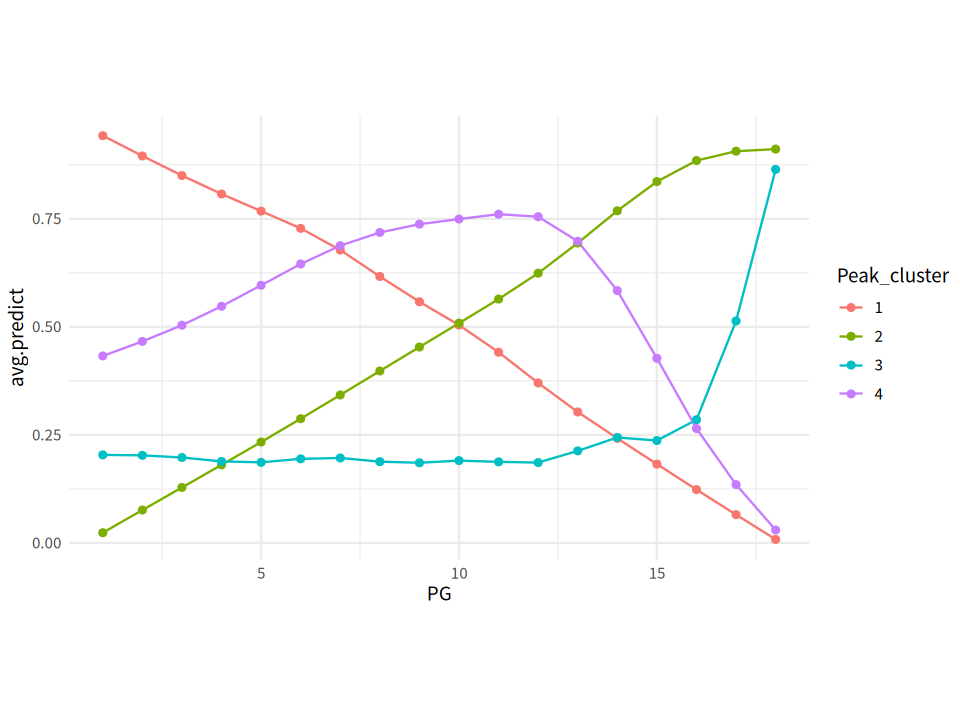

In [18]:
mod2 <- model.matrix(~gamres_clu_md-1)
mod2 <- t(t(mod2)/colSums(mod2))
colnames(mod2) <- sub("gamres_clu_md","",colnames(mod2))
dynavg_md <- t(scaled_gammat_md)%*%mod2
dynavg_md <- dynavg_md %>% 
  as_tibble(rownames = 'PG') %>%
  mutate(PG = as.integer(sub("group","",sub("PG","",PG)))) %>%
  gather(key = cluster,value = avg.predict,-PG)
dynavg_md %>%
  ggplot(aes(PG,avg.predict,color = cluster)) + 
    geom_line() + geom_point() +
    theme_minimal() +
    theme(aspect.ratio = .6)  + labs(color = 'Peak_cluster') #+ ggsci::scale_colour_npg()

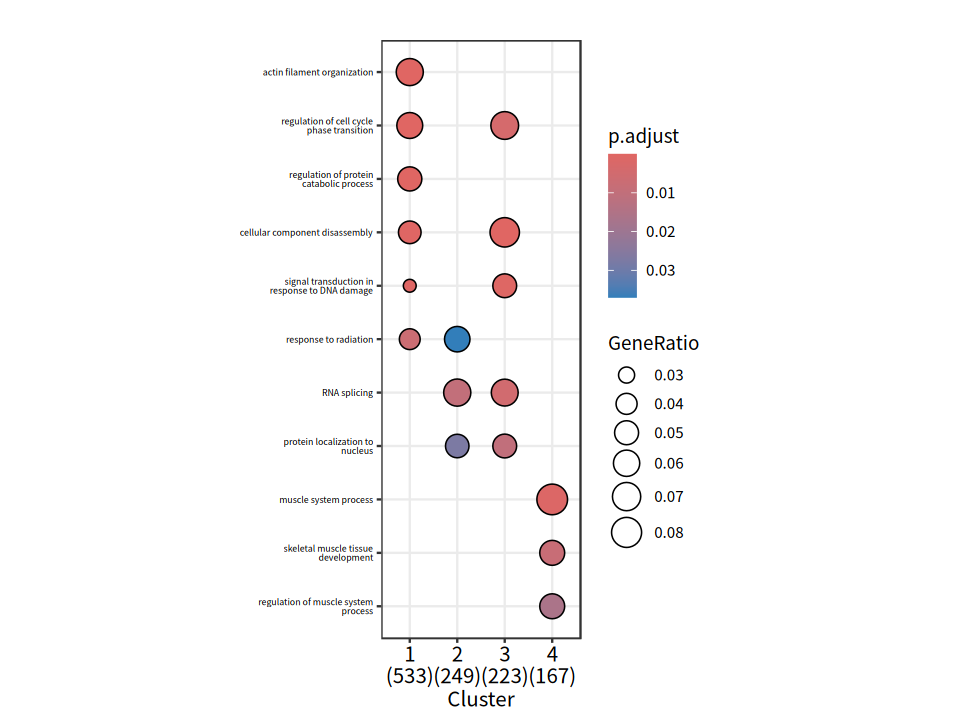

In [19]:
genes_md <- gamres_clu_md %>%
  enframe() %>%
  with(split(name,value)) %>%
  map(~olcount(
    reg2gr(.x) %>% extend(-1000,-1000),
    mgene_coding %>% flank(width = 2000,both = F,start = T),
    symbol = TRUE
    ) %>%
    mutate(
      reg = .x[as.integer(queryHits)]) %>%
      filter(
        !str_detect(subjectHits,'Gm'),
        !str_detect(subjectHits,'Rik'),
        !str_detect(subjectHits,'Rik2')
        ) %>%
      left_join(peakinfo_md,by = 'reg') %>%
      select(subjectHits,var) %>%
      slice_max(order_by = var,n = 1,by = subjectHits) %>%
      distinct() %>%
      arrange(-var) %>%
      pull(subjectHits) 
    )
ont_mdgenes <- compclus(genes_md,simplify = T)
clusterProfiler::dotplot(ont_mdgenes,showCategory = 3) + 
  theme(aspect.ratio = 3,axis.text.y = element_text(size = 5))

### Myog dynamics

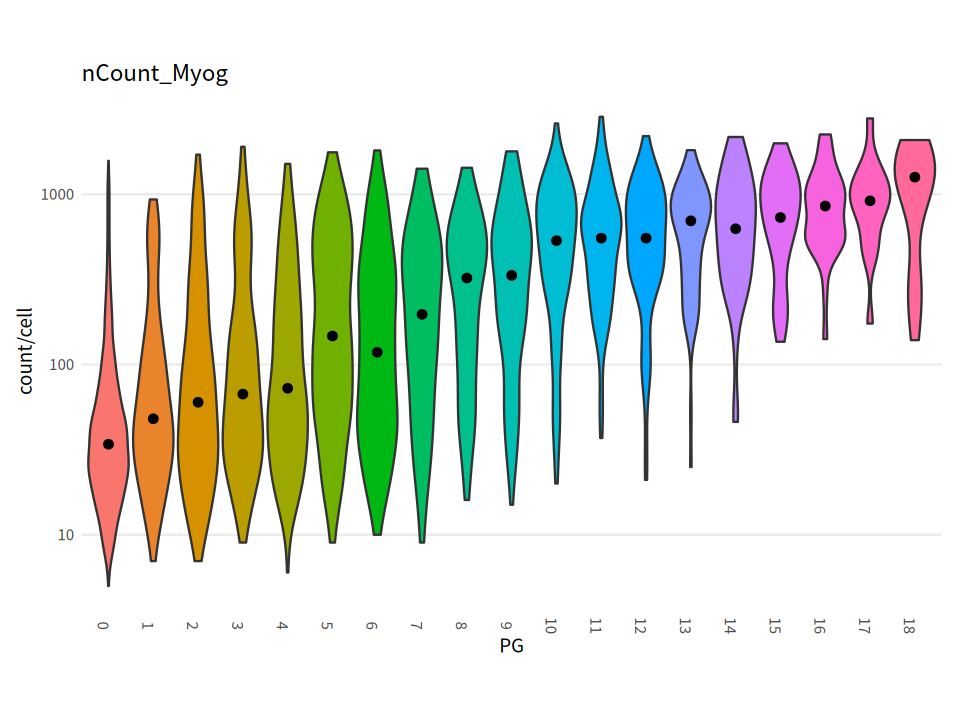

In [ ]:
so_mg <- readRDS('data/seuratObject_nih3t3_Myog_RNAPII-Myog.rds')
nih3t3mg <- subset(JoinLayers(nih3t3tf),pair == 'Myog')
nih3t3mg <- AddMetaData(nih3t3mg,so_mg$nCount_peaks,'nCount_Myog')

vlnplot(nih3t3mg[,!is.na(nih3t3mg$PG)],feature = 'nCount_Myog',group.by = 'PG') +
  stat_summary(fun = median,size = .3) + scale_y_log10() +
  theme(
    aspect.ratio = .6,
    axis.text.x = element_text(angle = -90) 
    ) +
  labs(y = 'count/cell')

In [21]:
mat_mg <- GetAssayData(so_mg,layer = 'data')
cells <- intersect(rownames(tab_pt2_),colnames(mat_mg))
mod1 <- with(tab_pt2_[cells,],model.matrix(~PG - 1))
mat_mg <- mat_mg[,cells]
mat_mg <- mat_mg[rowSums(mat_mg>0)>=10,]

nfrag <- (mat_mg>0) %*% mod1
mod1 <- 300*t(t(mod1)/colSums(mod1))
avg_mat_mg <- mat_mg %*% mod1

peakinfo_mg <- tibble(
  reg = rownames(avg_mat_mg),
  nFrag = rowSums(nfrag),
  nbin = rowSums(avg_mat_mg != 0),
  var = apply(mat_mg,1,var)
  )
usereg <- peakinfo_mg %>%
  filter(var >= 0.2,nbin >= 5) %>%
  pull(reg)

avg_mat_mg <- avg_mat_mg[usereg,]
maxbin <- ncol(avg_mat_mg)
scaled_avg_mat_mg <- t(scale(t(avg_mat_mg)))
gamres_mg <- tibble(
  peak = rownames(scaled_avg_mat_mg)
  ) %>%
  mutate(
    model = map(peak,~mgcv::gam(
      formula = y~s(x,bs = 'cs'),
      data = data.frame(x = 1:maxbin,y = scaled_avg_mat_mg[.x,])
    ),.progress = TRUE),
    pred = map(model,~tibble(
      PG = 1:maxbin,
      predict = predict(.x)
    ),.progress = TRUE)
  )
gammat_mg <- gamres_mg %>%
  select(-model) %>% unnest(pred) %>%
  spread(PG,predict) %>% 
  tib2df() %>% as.matrix()
scaled_gammat_mg <- gammat_mg %>% 
  apply(1,function(x) (x-min(x))/max(x-min(x))) %>% t()

 ■                                  1% |  ETA:  1m

 ■■                                 5% |  ETA:  1m

 ■■■■                               8% |  ETA:  1m

 ■■■■■                             12% |  ETA:  1m

 ■■■■■■                            15% |  ETA:  1m

 ■■■■■■■                           19% |  ETA:  1m

 ■■■■■■■■                          22% |  ETA:  1m

 ■■■■■■■■■                         26% |  ETA:  1m

 ■■■■■■■■■■                        29% |  ETA:  1m

 ■■■■■■■■■■■                       33% |  ETA:  1m

 ■■■■■■■■■■■■                      36% |  ETA:  1m

 ■■■■■■■■■■■■■                     40% |  ETA:  1m

 ■■■■■■■■■■■■■■                    43% |  ETA: 49s

 ■■■■■■■■■■■■■■■                   46% |  ETA: 46s

 ■■■■■■■■■■■■■■■■                  50% |  ETA: 43s

 ■■■■■■■■■■■■■■■■■                 53% |  ETA: 40s

 ■■■■■■■■■■■■■■■■■■                57% |  ETA: 38s

 ■■■■■■■■■■■■■■■■■■■               60% |  ETA: 35s

 ■■■■■■■■■■■■■■■■■■■■              64% |  ETA: 32s

 ■■■■■■■■■■■

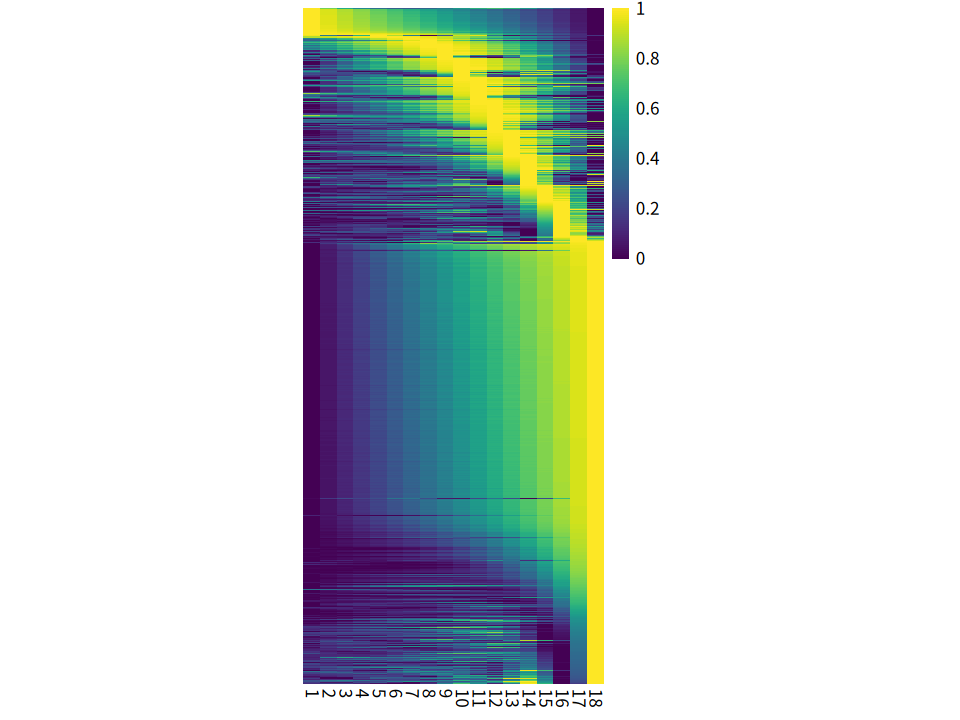

In [22]:
nbin <- ncol(scaled_gammat_mg)
heat_lev_mg <- scaled_gammat_mg %>% 
  as_tibble(rownames = 'reg') %>%
  gather(key = PG,value = value,-reg) %>%
  mutate(PG = as.integer(PG)) %>%
  nest(.by = reg) %>%
  mutate(
    summit = map_int(data,~with(.x,PG[which.max(value)])),
    sup = ifelse(summit < nbin/2,summit+1,summit-1),
    sup = map2_dbl(data,sup,~{ .x$value[.y] }),
    sup = ifelse(summit < nbin/2,sup,-sup)
    ) %>%
  arrange(summit,sup) %>%
  pull(reg)
pheatmap::pheatmap(
  scaled_gammat_mg[heat_lev_mg,],
  cluster_rows = F,cluster_cols = F,
  show_rownames = F,cellwidth = 10,border_color = NA,
  color = viridis::viridis(128),
  )

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


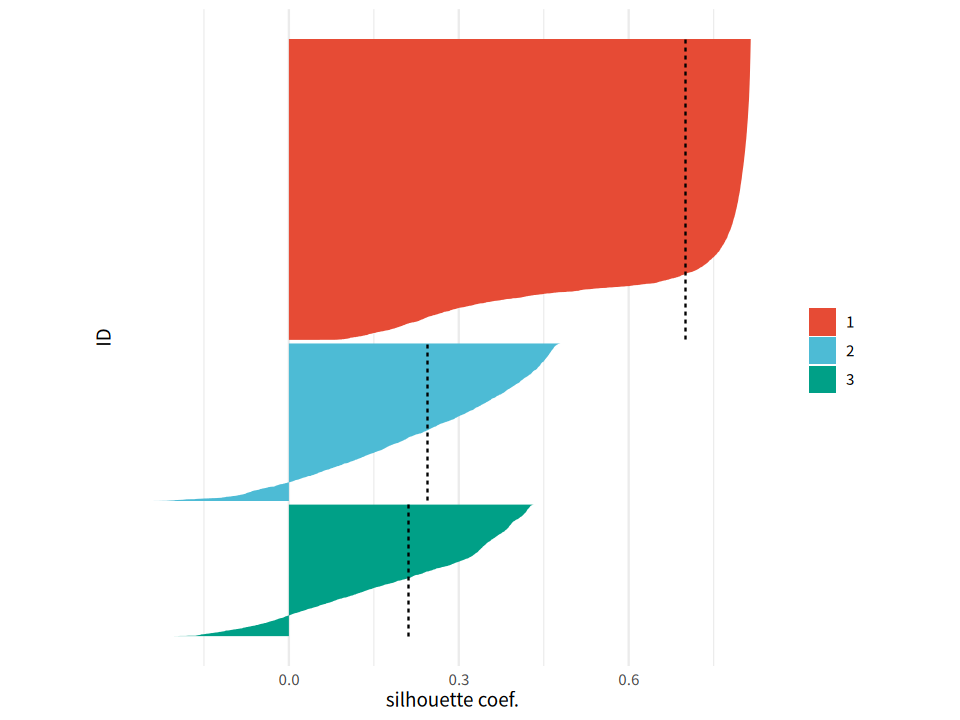

In [ ]:
k <- 3
set.seed(10); km <- kmeans(scaled_gammat_mg,centers = k)
lev <- with(km,table(cluster)) %>% sort(decreasing = TRUE) %>% names()
gamres_clu_mg <- as.factor(as.integer(factor(km$cluster,levels = lev))) %>%
  structure(names = names(km$cluster))
names(gamres_clu_mg) <- rownames(scaled_gammat_mg)
D <- dist(scaled_gammat_mg)
sil_use <- silh(D,gamres_clu_mg,1:k)
sil_use[[1]] + theme(aspect.ratio = 1) + ggsci::scale_fill_npg()

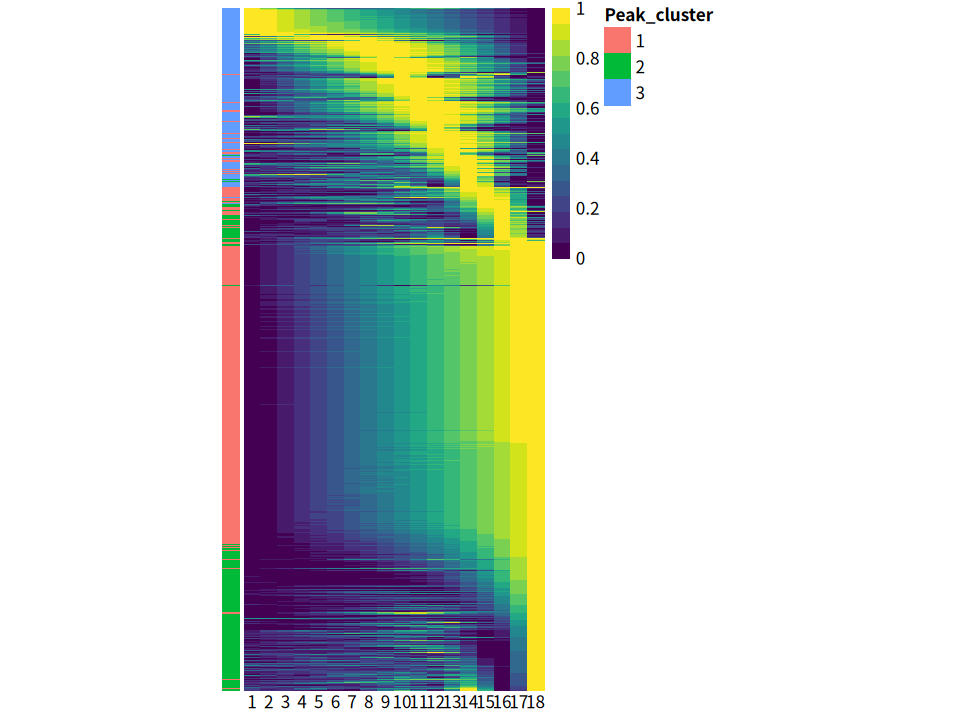

In [24]:
pal <- list(Peak_cluster = structure(ggColorHue(k),names = 1:k))
gr_que_df_mg_ <- enframe(gamres_clu_mg) %>%
  rename(reg = 1,Peak_cluster = 2) %>%
  mutate(Peak_cluster = as.character(Peak_cluster)) %>%
  tib2df()
pheatmap::pheatmap(
  scaled_gammat_mg[heat_lev_mg,],
  cluster_rows = F,cluster_cols = F,
  show_rownames = F,cellwidth = 10,border_color = NA,
  color = viridis::viridis(16),
  annotation_row = gr_que_df_mg_[heat_lev_mg,,drop = F],
  annotation_colors = pal,
  angle_col = 0,annotation_names_row = F
  )


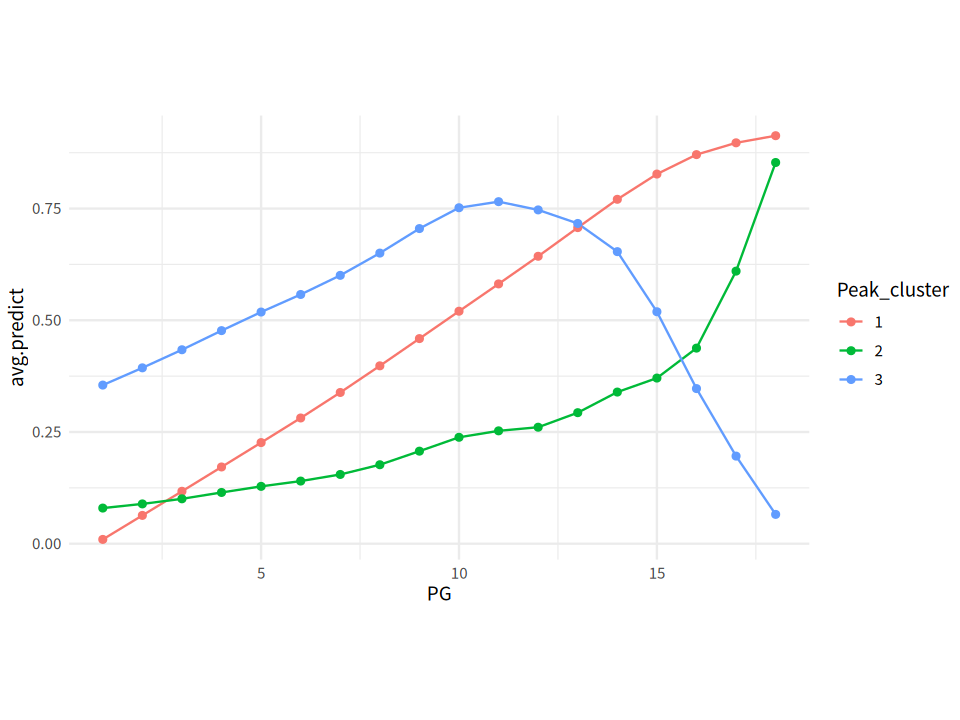

In [25]:
mod2 <- model.matrix(~gamres_clu_mg-1)
mod2 <- t(t(mod2)/colSums(mod2))
colnames(mod2) <- sub("gamres_clu_mg","",colnames(mod2))
dynavg_mg <- t(scaled_gammat_mg)%*%mod2
dynavg_mg <- dynavg_mg %>% 
  as_tibble(rownames = 'PG') %>%
  mutate(PG = as.integer(sub("group","",sub("PG","",PG)))) %>%
  gather(key = cluster,value = avg.predict,-PG)
dynavg_mg %>%
  ggplot(aes(PG,avg.predict,color = cluster)) + 
    geom_line() + geom_point() +
    theme_minimal() +
    theme(aspect.ratio = .6)  + labs(color = 'Peak_cluster') #+ ggsci::scale_colour_npg()

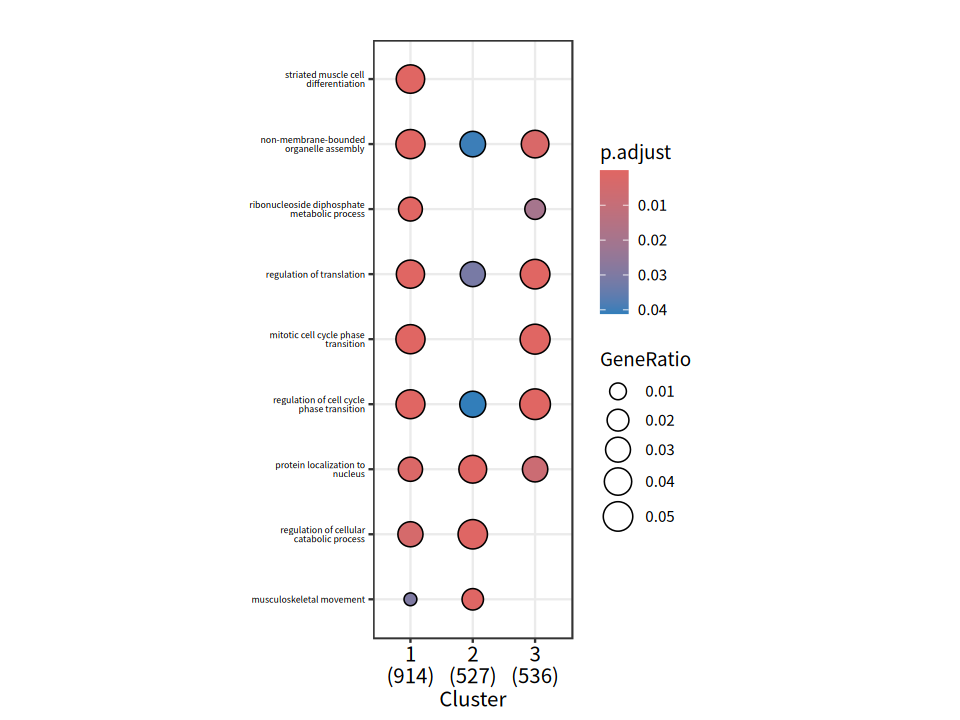

In [26]:
genes_mg <- gamres_clu_mg %>%
  enframe() %>%
  with(split(name,value)) %>%
  map(~olcount(
    reg2gr(.x) %>% extend(-1000,-1000),
    mgene_coding %>% flank(width = 2000,both = F,start = T),
    symbol = TRUE
    ) %>%
    mutate(
      reg = .x[as.integer(queryHits)]) %>%
      filter(
        !str_detect(subjectHits,'Gm'),
        !str_detect(subjectHits,'Rik'),
        !str_detect(subjectHits,'Rik2')
        ) %>%
      left_join(peakinfo_mg,by = 'reg') %>%
      select(subjectHits,var) %>%
      slice_max(order_by = var,n = 1,by = subjectHits) %>%
      distinct() %>%
      arrange(-var) %>%
      pull(subjectHits) 
    )
ont_mggenes <- compclus(genes_mg,simplify = T)
clusterProfiler::dotplot(ont_mggenes,showCategory = 3) + 
  theme(aspect.ratio = 3,axis.text.y = element_text(size = 5))

In [27]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /usr/local/packages/mambaforge/lib/libmkl_gf_lp64.so.2;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=ja_JP.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ja_JP.UTF-8        LC_COLLATE=ja_JP.UTF-8    
 [5] LC_MONETARY=ja_JP.UTF-8    LC_MESSAGES=ja_JP.UTF-8   
 [7] LC_PAPER=ja_JP.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ja_JP.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Tokyo
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] lubridate_1.9.3             forcats_1.0.0              
 [3] stringr_1.5.1               dplyr_1.1.4                
 [5] purrr_1.0.4                 readr_2.1.5                
 [7] tidyr_1.3.1                 tibble_3.2.1      